In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
df = df.drop(columns=['volume','change', 'low', 'high', 'open'])
df = df.rename(columns={"value": "wallets"})
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
df.dtypes

#https://dcresearch.medium.com/metcalfes-law-and-bitcoin-s-value-2b99c7efd1fa

date       datetime64[ns]
price             float64
wallets             int64
address           float64
mined             float64
dtype: object

In [2]:
df['Metcafe']=df['address']**2
# df["Metcafe"] = df["Metcafe"].map("{:.1f}".format)
df['value'] = df['Metcafe']/df['mined']
df["value"] = df["value"].map("{:.2f}".format)
df['value']=df['value'].astype("float")
df['networkvalue'] = df["price"] - df["value"]
df.dtypes


date            datetime64[ns]
price                  float64
wallets                  int64
address                float64
mined                  float64
Metcafe                float64
value                  float64
networkvalue           float64
dtype: object

In [3]:
df

,date,price,wallets,address,mined,Metcafe,value,networkvalue
0,2010-09-25,0.1,2,656.0,4109450.00,4.303360e+05,0.10,0.00
1,2010-09-26,0.1,2,444.0,4110750.00,1.971360e+05,0.05,0.05
2,2010-09-27,0.1,2,1070.0,4132150.00,1.144900e+06,0.28,-0.18
3,2010-09-28,0.1,2,1503.0,4133200.00,2.259009e+06,0.55,-0.45
4,2010-09-29,0.1,2,1049.0,4148050.00,1.100401e+06,0.27,-0.17
...,...,...,...,...,...,...,...,...
4381,2022-10-21,19162.6,84879615,924681.0,19185681.25,8.550350e+11,44566.31,-25403.71
4382,2022-10-22,19204.8,84888147,830404.0,19186618.75,6.895708e+11,35940.19,-16735.39
4383,2022-10-23,19571.2,84893809,804140.0,19187600.00,6.466411e+11,33700.99,-14129.79
4384,2022-10-24,19331.5,84902680,919344.0,19188556.25,8.451934e+11,44046.74,-24715.24


In [4]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

n_years =2
period = n_years * 365
future = m.make_future_dataframe(periods = period)
forecast = m.predict(future)

15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:34 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5111,2024-10-20,67579.622795,57514.920236,76847.380412
5112,2024-10-21,67786.517389,58611.683334,77837.057048
5113,2024-10-22,67956.169026,58063.207288,77041.185888
5114,2024-10-23,68193.892712,58368.229785,77323.487544
5115,2024-10-24,68339.782496,58375.200897,77485.847616


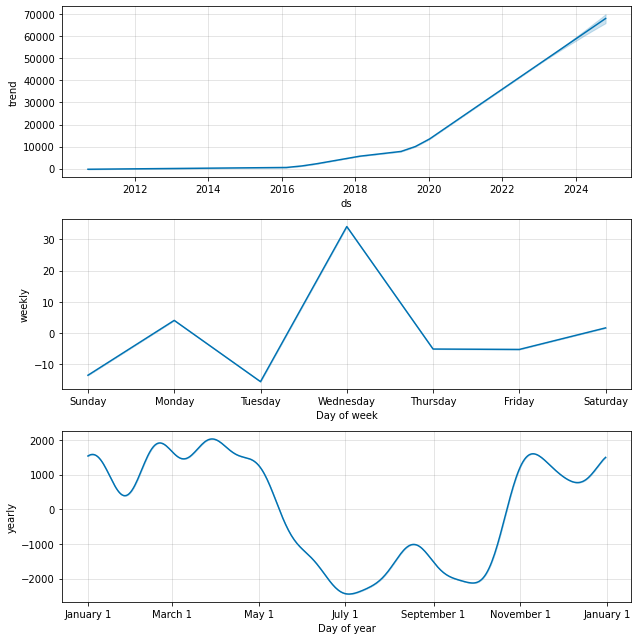

In [6]:
fig2 = m.plot_components(forecast)

In [7]:
df_train = df[['date', 'price']]
df_train = df_train.rename(columns = {"date":"ds", "price":"y"})

m = Prophet()
m.fit(df_train)

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

15:53:36 - cmdstanpy - INFO - Chain [1] start processing
15:53:37 - cmdstanpy - INFO - Chain [1] done processing
15:53:37 - cmdstanpy - INFO - Chain [1] start processing
15:53:38 - cmdstanpy - INFO - Chain [1] done processing


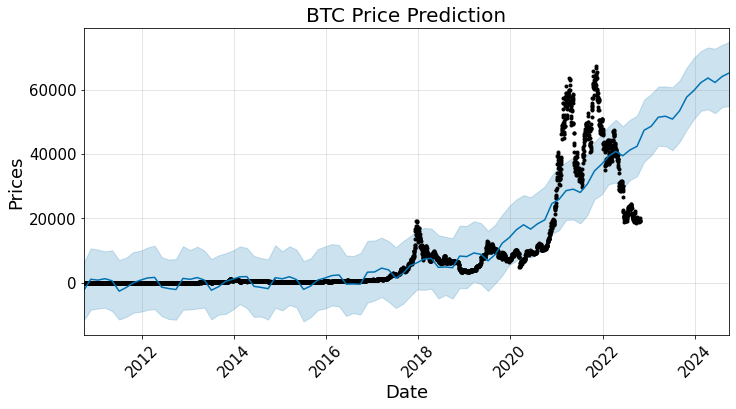

In [8]:
# Create a data frame that lists dates from Oct - Dec 2017
insample = pd.DataFrame(pd.date_range("2010-09-25", "2024-10-01", periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2010-09-25', '2024-10-01'])) 
plt.show();
# plt.savefig("../static/prices.png")

In [11]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(name="Actual", x=df_train['ds'], y=df_train['y'], legendrank=4))
fig.add_trace(go.Scatter(name="Middle Bound Prediction", x=prediction['ds'], y=prediction['yhat'], legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound Prediction", x=prediction['ds'], y=prediction['yhat_lower'], legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound Prediction", x=prediction['ds'], y=prediction['yhat_upper'], legendrank=1))

fig.update_xaxes(
    rangeslider_visible = True,
    rangeselector = dict(
        buttons = list([
            dict(count = 1, label = "1m", step = "month", stepmode = "backward"),
            dict(count = 6, label = "6m", step = "month", stepmode = "backward"),
            dict(count = 1, label = "YTD", step = "year", stepmode = "todate"),
            dict(count = 1, label = "1y", step = "year", stepmode = "backward"),
            dict(step = "all")
        ])
    )
)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prices and Date Prediction')
fig.update_yaxes(ticklabelposition="inside top", title="Bitcoin Prices")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=20)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.show()
fig.write_html('../static/prices.html')